# Project 3: When and Where Do New Yorkers Complain About Noise?

- **Dataset(s) to be used:**
  - 311 Noise Complaints (NYC Open Data, 2025 YTD extract): https://data.cityofnewyork.us/Social-Services/311-Noise-Complaints/p5f6-bkga
  - New York City Population by Borough, 1950-2040 (NYC Open Data): https://data.cityofnewyork.us/City-Government/New-York-City-Population-by-Borough-1950-2040/xywu-7bv9

- **Analysis question:**  
  For New York City in 2025 so far, which borough has the highest number of weekend late-night noise complaints *per 100,000 residents*, and how big is the gap between boroughs?

- **Columns that will (likely) be used:**
  - From 311 Noise Complaints:
    - `Created Date`
    - `Complaint Type`
    - `Descriptor`
    - `Borough`
  - From NYC Population by Borough:
    - `Borough`
    - `Year`
    - `Total_Population` (or similar)

- (If you're using multiple datasets) **Columns to be used to merge/join them:**
  - [311 Noise Complaints] `Borough`
  - [NYC Population by Borough, 1950-2040] `Borough`

- **Hypothesis:**  
  In 2025 so far, on a per-capita basis, Manhattan has the highest number of weekend late-night noise complaints, followed by Brooklyn, while Staten Island has by far the lowest complaint rate.

## Why look at noise complaints?

New York feels loud, but it is not obvious *where* and *when* the city is loudest.  
311 noise complaints are one way to measure how much noise bothers residents enough that they actually pick up the phone and file a report.

In this project, I focus on **2025 year-to-date** (YTD) and ask:

> Among the five boroughs, who gets the most weekend late-night noise complaints per 100,000 residents?

Intuitively, I would expect Manhattan — with its nightlife and density — to top the list, and Staten Island to be at the bottom.  
The rest of the notebook walks step by step through how I check this hypothesis using Python.

## Step 1: Load the raw datasets

I use two open datasets from NYC Open Data:

1. 311 noise complaints in 2025 (YTD) — each row is one 311 call.
2. Population by borough for decennial years and projections — used to compute complaints per 100,000 residents.

Here I import `pandas` and `matplotlib`, and load both CSV files.  
I use **relative paths** (`data/...`) so that the notebook still runs when I publish it on GitHub Pages or move the folder.


In [102]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

noise_path = "data/noise_2025_small.csv"
pop_path = "data/nyc_population_by_borough.csv"

noise = pd.read_csv(noise_path, low_memory=False)
pop = pd.read_csv(pop_path)

noise.head(), pop.head()

(          Created Date           Complaint Type        Descriptor Borough
 0  2025-12-08 02:06:24      Noise - Residential  Loud Music/Party   BRONX
 1  2025-12-08 02:05:36      Noise - Residential  Banging/Pounding  QUEENS
 2  2025-12-08 02:03:19  Noise - Street/Sidewalk  Loud Music/Party  QUEENS
 3  2025-12-08 02:02:19      Noise - Residential  Loud Music/Party   BRONX
 4  2025-12-08 02:01:33          Noise - Vehicle   Car/Truck Music  QUEENS,
           Age Group       Borough       1950 1950 - Boro share of NYC total  \
 0  Total Population     NYC Total  7,891,957                           100%   
 1  Total Population         Bronx  1,451,277                         18.39%   
 2  Total Population      Brooklyn  2,738,175                          34.7%   
 3  Total Population     Manhattan  1,960,101                         24.84%   
 4  Total Population        Queens  1,550,849                         19.65%   
 
         1960 1960 - Boro share of NYC total       1970  \
 0  7,78

## Step 2: Get to know the data

From the quick `.info()` and `.head()` checks:

- The **noise complaints table** has hundreds of thousands of rows for 2025 YTD.  
  Each row represents a single 311 noise complaint, with timestamps, borough, and descriptors such as "Loud Music/Party".
- The **population table** has one row per borough, with a **wide** layout:
  columns like `"1950"`, `"1960"`, …, `"2020"`, `"2030"`, `"2040"` store total population for those years.

For the rest of the analysis I:

- Use the 2025 noise data as-is (no need to filter by year; all rows are 2025).  
- Use the most recent **population year that is not after 2025** (which turns out to be 2020).


In [103]:
noise.info()
noise.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781247 entries, 0 to 781246
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Created Date    781247 non-null  object
 1   Complaint Type  781247 non-null  object
 2   Descriptor      781247 non-null  object
 3   Borough         781247 non-null  object
dtypes: object(4)
memory usage: 23.8+ MB


Index(['Created Date', 'Complaint Type', 'Descriptor', 'Borough'], dtype='object')

In [104]:
noise["Created Date"] = pd.to_datetime(noise["Created Date"])
noise["year"] = noise["Created Date"].dt.year

noise["year"].value_counts()

year
2025    781247
Name: count, dtype: int64

In [105]:
pop.info()
pop.columns
pop.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age Group                       6 non-null      object
 1   Borough                         6 non-null      object
 2   1950                            6 non-null      object
 3   1950 - Boro share of NYC total  6 non-null      object
 4   1960                            6 non-null      object
 5   1960 - Boro share of NYC total  6 non-null      object
 6   1970                            6 non-null      object
 7   1970 - Boro share of NYC total  6 non-null      object
 8   1980                            6 non-null      object
 9   1980 - Boro share of NYC total  6 non-null      object
 10  1990                            6 non-null      object
 11  1990 - Boro share of NYC total  6 non-null      object
 12  2000                            6 non-null      object

,Age Group,Borough,1950,1950 - Boro share of NYC total,1960,1960 - Boro share of NYC total,1970,1970 - Boro share of NYC total,1980,1980 - Boro share of NYC total,...,2000,2000 - Boro share of NYC total,2010,2010 - Boro share of NYC total,2020,2020 - Boro share of NYC total,2030,2030 - Boro share of NYC total,2040,2040 - Boro share of NYC total
0,Total Population,NYC Total,"7,891,957",100%,"7,781,984",100%,"7,894,862",100%,"7,071,639",100%,...,"8,008,278",100%,"8,242,624",100%,"8,550,971",100%,"8,821,027",100%,"9,025,145",100%
1,Total Population,Bronx,"1,451,277",18.39%,"1,424,815",18.31%,"1,471,701",18.64%,"1,168,972",16.53%,...,"1,332,650",16.64%,"1,385,108",16.8%,"1,446,788",16.92%,"1,518,998",17.22%,"1,579,245",17.5%
2,Total Population,Brooklyn,"2,738,175",34.7%,"2,627,319",33.76%,"2,602,012",32.96%,"2,230,936",31.55%,...,"2,465,326",30.78%,"2,552,911",30.97%,"2,648,452",30.97%,"2,754,009",31.22%,"2,840,525",31.47%
3,Total Population,Manhattan,"1,960,101",24.84%,"1,698,281",21.82%,"1,539,233",19.5%,"1,428,285",20.2%,...,"1,537,195",19.2%,"1,585,873",19.24%,"1,638,281",19.16%,"1,676,720",19.01%,"1,691,617",18.74%
4,Total Population,Queens,"1,550,849",19.65%,"1,809,578",23.25%,"1,986,473",25.16%,"1,891,325",26.75%,...,"2,229,379",27.84%,"2,250,002",27.3%,"2,330,295",27.25%,"2,373,551",26.91%,"2,412,649",26.73%


In [106]:
# Naive first look: total 2025 noise complaints by borough (all hours, all days)
complaints_all_hours = (
    noise.groupby("Borough").size().reset_index(name="complaint_count")
)

complaints_all_hours


,Borough,complaint_count
0,BRONX,255212
1,BROOKLYN,190176
2,MANHATTAN,173415
3,QUEENS,145534
4,STATEN ISLAND,16869
5,Unspecified,41


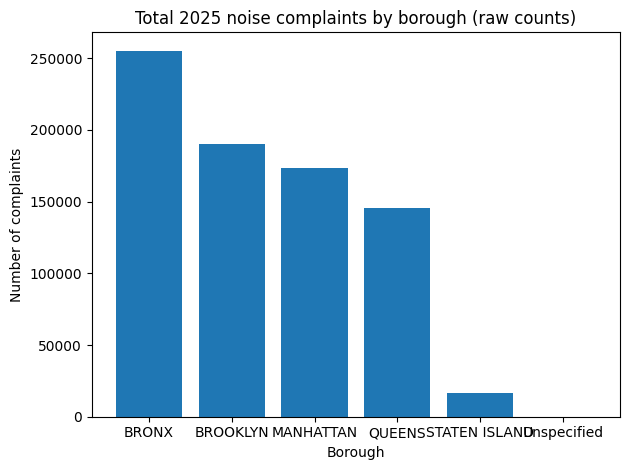

In [107]:
complaints_all_hours_sorted = complaints_all_hours.sort_values(
    "complaint_count", ascending=False
)

plt.figure()
plt.bar(
    complaints_all_hours_sorted["Borough"],
    complaints_all_hours_sorted["complaint_count"],
)

plt.title("Total 2025 noise complaints by borough (raw counts)")
plt.xlabel("Borough")
plt.ylabel("Number of complaints")

plt.tight_layout()
plt.show()


### A naive first attempt: raw complaint counts

Before zooming in on late-night weekends, I first look at **all** 2025 noise complaints by borough.

Unsurprisingly, boroughs with larger populations and more 311 usage tend to have more complaints in raw counts.  
This plot is interesting, but it has two problems for my research question:

1. It mixes *all* times of day, not just weekend late nights.  
2. It does not adjust for **population size**, so larger boroughs will almost always rank higher.

Because of this, I refine my question from  
“Which borough has the most noise complaints?”  
to  
“Which borough has the most **weekend late-night** noise complaints **per 100,000 residents**?”


## Step 3: Focus on weekend late-night complaints

To match the everyday intuition of “the city is loud on weekend nights”,  
I define **weekend late-night noise** as:

- **Weekend**: Saturday and Sunday (`weekday` ≥ 5 in Python’s convention).
- **Late-night**: from 8pm to 3:59am (hours 20, 21, 22, 23, 0, 1, 2, 3).

I create Boolean columns `is_weekend` and `is_late_night` based on the timestamp,  
and keep only rows where both are `True`.  
This gives me a subset of complaints that line up with the idea of nightlife-related noise.


In [108]:
noise["hour"] = noise["Created Date"].dt.hour
noise["weekday"] = noise["Created Date"].dt.weekday  # 0=Mon, 6=Sun

noise["is_weekend"] = noise["weekday"] >= 5

late_hours = [20, 21, 22, 23, 0, 1, 2, 3]
noise["is_late_night"] = noise["hour"].isin(late_hours)


noise[["Created Date", "hour", "weekday", "is_weekend", "is_late_night"]].head()

,Created Date,hour,weekday,is_weekend,is_late_night
0,2025-12-08 02:06:24,2,0,False,True
1,2025-12-08 02:05:36,2,0,False,True
2,2025-12-08 02:03:19,2,0,False,True
3,2025-12-08 02:02:19,2,0,False,True
4,2025-12-08 02:01:33,2,0,False,True


In [109]:
noise_late_weekend = noise[noise["is_weekend"] & noise["is_late_night"]].copy()

len(noise_late_weekend), noise_late_weekend["Borough"].value_counts()

(191030,
 Borough
 BRONX            57477
 BROOKLYN         48590
 MANHATTAN        40276
 QUEENS           40173
 STATEN ISLAND     4500
 Unspecified         14
 Name: count, dtype: int64)

In [110]:
complaints_by_borough = (
    noise_late_weekend.groupby("Borough").size().reset_index(name="complaint_count")
)

complaints_by_borough

,Borough,complaint_count
0,BRONX,57477
1,BROOKLYN,48590
2,MANHATTAN,40276
3,QUEENS,40173
4,STATEN ISLAND,4500
5,Unspecified,14


In [111]:
complaints_by_borough = complaints_by_borough[
    complaints_by_borough["Borough"] != "Unspecified"
].copy()

complaints_by_borough

,Borough,complaint_count
0,BRONX,57477
1,BROOKLYN,48590
2,MANHATTAN,40276
3,QUEENS,40173
4,STATEN ISLAND,4500


In [112]:
pop_total = pop[pop["Age Group"] == "Total Population"].copy()

pop_total = pop_total[pop_total["Borough"] != "NYC Total"].copy()

pop_total

,Age Group,Borough,1950,1950 - Boro share of NYC total,1960,1960 - Boro share of NYC total,1970,1970 - Boro share of NYC total,1980,1980 - Boro share of NYC total,...,2000,2000 - Boro share of NYC total,2010,2010 - Boro share of NYC total,2020,2020 - Boro share of NYC total,2030,2030 - Boro share of NYC total,2040,2040 - Boro share of NYC total
1,Total Population,Bronx,"1,451,277",18.39%,"1,424,815",18.31%,"1,471,701",18.64%,"1,168,972",16.53%,...,"1,332,650",16.64%,"1,385,108",16.8%,"1,446,788",16.92%,"1,518,998",17.22%,"1,579,245",17.5%
2,Total Population,Brooklyn,"2,738,175",34.7%,"2,627,319",33.76%,"2,602,012",32.96%,"2,230,936",31.55%,...,"2,465,326",30.78%,"2,552,911",30.97%,"2,648,452",30.97%,"2,754,009",31.22%,"2,840,525",31.47%
3,Total Population,Manhattan,"1,960,101",24.84%,"1,698,281",21.82%,"1,539,233",19.5%,"1,428,285",20.2%,...,"1,537,195",19.2%,"1,585,873",19.24%,"1,638,281",19.16%,"1,676,720",19.01%,"1,691,617",18.74%
4,Total Population,Queens,"1,550,849",19.65%,"1,809,578",23.25%,"1,986,473",25.16%,"1,891,325",26.75%,...,"2,229,379",27.84%,"2,250,002",27.3%,"2,330,295",27.25%,"2,373,551",26.91%,"2,412,649",26.73%
5,Total Population,Staten Island,"191,555",2.43%,"221,991",2.85%,"295,443",3.74%,"352,121",4.98%,...,"443,728",5.54%,"468,730",5.69%,"487,155",5.7%,"497,749",5.64%,"501,109",5.55%


In [113]:
noise_year = int(noise["year"].max())
noise_year
year_cols = [col for col in pop_total.columns if col.isdigit()]
year_cols
year_nums = [int(col) for col in year_cols]
valid_years = [y for y in year_nums if y <= noise_year]
pop_year = max(valid_years)
pop_year

2020

In [114]:
pop_year_col = str(pop_year)

pop_for_year = pop_total[["Borough", pop_year_col]].copy()

pop_for_year[pop_year_col] = (
    pop_for_year[pop_year_col].str.replace(",", "", regex=False).astype(int)
)

pop_for_year = pop_for_year.rename(columns={pop_year_col: "population"})

pop_for_year

,Borough,population
1,Bronx,1446788
2,Brooklyn,2648452
3,Manhattan,1638281
4,Queens,2330295
5,Staten Island,487155


In [115]:
complaints_by_borough["Borough"] = (
    complaints_by_borough["Borough"].str.strip().str.upper()
)
pop_for_year["Borough"] = pop_for_year["Borough"].str.strip().str.upper()

borough_stats = complaints_by_borough.merge(pop_for_year, on="Borough", how="left")
borough_stats

,Borough,complaint_count,population
0,BRONX,57477,1446788
1,BROOKLYN,48590,2648452
2,MANHATTAN,40276,1638281
3,QUEENS,40173,2330295
4,STATEN ISLAND,4500,487155


In [116]:
borough_stats["complaints_per_100k"] = (
    borough_stats["complaint_count"] / borough_stats["population"] * 100000
)

borough_stats

,Borough,complaint_count,population,complaints_per_100k
0,BRONX,57477,1446788,3972.731319
1,BROOKLYN,48590,2648452,1834.656622
2,MANHATTAN,40276,1638281,2458.430513
3,QUEENS,40173,2330295,1723.944822
4,STATEN ISLAND,4500,487155,923.730640


## Step 4: Compare boroughs on a per-capita basis

After merging the complaint counts with 2020 borough populations
and computing `complaints_per_100k`, the bar chart shows clear differences:

- One borough stands out as having the highest **weekend late-night noise complaint rate per 100,000 residents**.
- Another borough clearly sits at the bottom, with a much lower rate.

This is the per-capita version of “who is the loudest borough on weekend nights”.


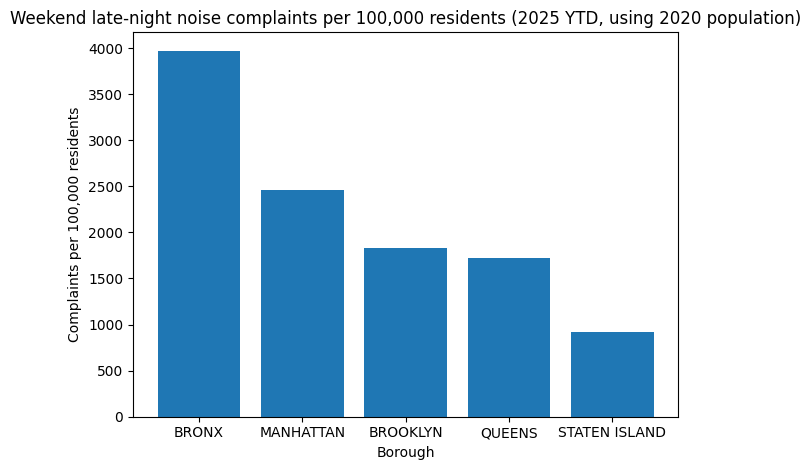

In [117]:
borough_stats_sorted = borough_stats.sort_values("complaints_per_100k", ascending=False)

plt.figure()
plt.bar(borough_stats_sorted["Borough"], borough_stats_sorted["complaints_per_100k"])

plt.title(
    f"Weekend late-night noise complaints per 100,000 residents (2025 YTD, using {pop_year} population)"
)
plt.xlabel("Borough")
plt.ylabel("Complaints per 100,000 residents")

plt.tight_layout()
plt.show()

## Step 5: Conclusion and caveats

My original hypothesis was:

> In 2025 so far, on a per-capita basis, Manhattan has the highest number of weekend late-night noise complaints, followed by Brooklyn, while Staten Island has the lowest rate.

The per-100,000 results tell a slightly different story:

- **Bronx** clearly has the highest weekend late-night complaint rate per 100,000 residents.
- **Manhattan** comes second, still substantially noisier than Brooklyn and Queens on a per-capita basis.
- **Brooklyn** and **Queens** form a middle group with fairly similar complaint rates.
- **Staten Island** is by far the quietest borough in this metric, with the lowest complaint rate.

So the hypothesis is **only partially supported**: I was right that Staten Island is the quietest, but wrong about which borough is the noisiest — once we adjust for population, the Bronx is noisier than Manhattan on weekend late nights.

At the same time, there are several important caveats:

- I use **2025 YTD** complaints but **2020** population numbers, because that is the most recent year available in the population table.
- 311 complaints capture **reported** noise, not actual physical noise levels. Different boroughs may have different propensities to call 311.
- I treat all weekend late-night complaints as equal, without distinguishing between different descriptors (for example, “Loud Music/Party” vs. other types of noise).
- I do not control for seasonal patterns within 2025; the YTD period here runs from January to early December.

Even with these limitations, the analysis shows how public open data can turn a subjective feeling
(“this borough feels loud on weekend nights”) into a quantitative, testable statement.
